# New York City Airbnb

This project predicts Airbnb host popularity using a stacked machine learning model that combines XGBoost and Random Forest with a Ridge Regression meta-learner. The notebook constructs a custom popularity score using review volume, listing price, and recent activity, making this a valuable tool for host performance analytics.

In [2068]:
import opendatasets as od
import os

In [2069]:
dataset_url = 'https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data'
data_dir = 'new-york-city-airbnb-open-data'
od.download(dataset_url)
os.listdir(data_dir)

Skipping, found downloaded files in "./new-york-city-airbnb-open-data" (use force=True to force download)


['New_York_City_.png', 'AB_NYC_2019.csv']

# Feature Engineering

In [2070]:
import pandas as pd
import numpy as np

In [2071]:
df = pd.read_csv(os.path.join(data_dir, 'AB_NYC_2019.csv'))
df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [2072]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [2073]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [2074]:
df['minimum_nights'].sort_values(ascending=False)

5767     1250
2854     1000
38664     999
13404     999
26341     999
         ... 
38503       1
38504       1
13834       1
28305       1
0           1
Name: minimum_nights, Length: 48895, dtype: int64

In [2075]:
df.drop([5767,2854,38664,13404,26341], inplace=True)

In [2076]:
df['number_of_reviews'].sort_values(ascending=False)

11759    629
2031     607
2030     597
2015     594
13495    576
        ... 
17853      0
40845      0
17848      0
17847      0
48894      0
Name: number_of_reviews, Length: 48890, dtype: int64

In [2077]:
df.drop([11759,2031,2030,2015,13495], inplace=True)

In [2078]:
df.drop(['id'], axis=1, inplace=True)

In [2079]:
df.isnull().sum()

name                                 15
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10050
reviews_per_month                 10050
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [2080]:
df.dropna(subset=['name','host_name'], inplace=True)

In [2081]:
mean_val = df['reviews_per_month'].mean()
df['reviews_per_month'] = df['reviews_per_month'].apply(
    lambda x: mean_val if pd.isna(x) or x <= 0 else x
)

In [2082]:
df.isnull().sum()

name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10036
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [2083]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1.372166,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0


In [2084]:
df.drop(['name'], axis=1, inplace=True)

In [2085]:
df.head()

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365
1,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355
2,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1.372166,1,365
3,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194
4,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0


### DATA VISUALIZATION

In [2086]:
import matplotlib.pyplot as plt
import seaborn as sns

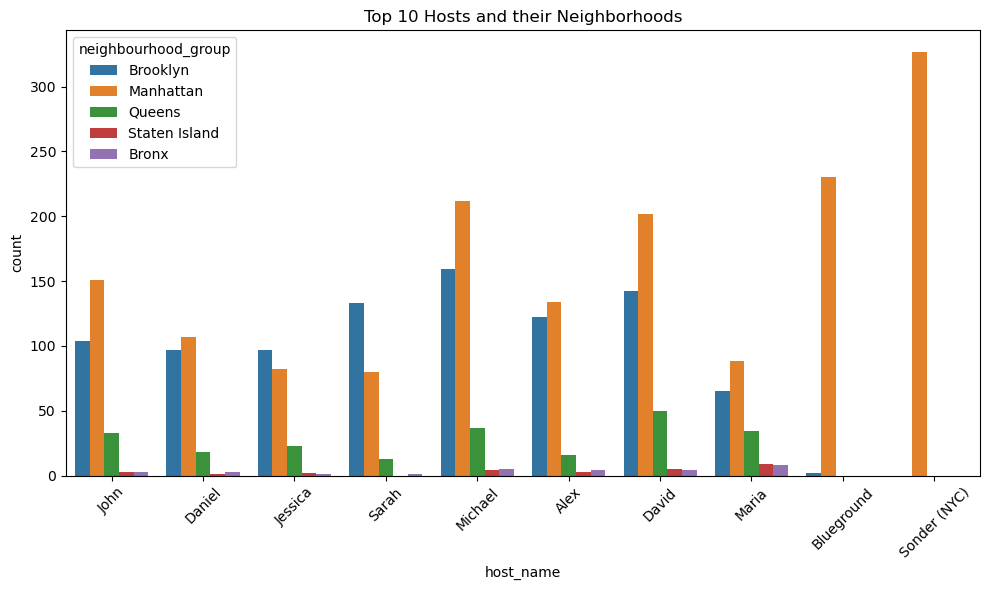

In [2087]:
plt.figure(figsize=(10, 6))
top_hosts = df['host_name'].value_counts().head(10).index
sns.countplot(data=df[df['host_name'].isin(top_hosts)], 
              x='host_name', hue='neighbourhood_group')
plt.xticks(rotation=45)
plt.title('Top 10 Hosts and their Neighborhoods')
plt.tight_layout()
plt.show()


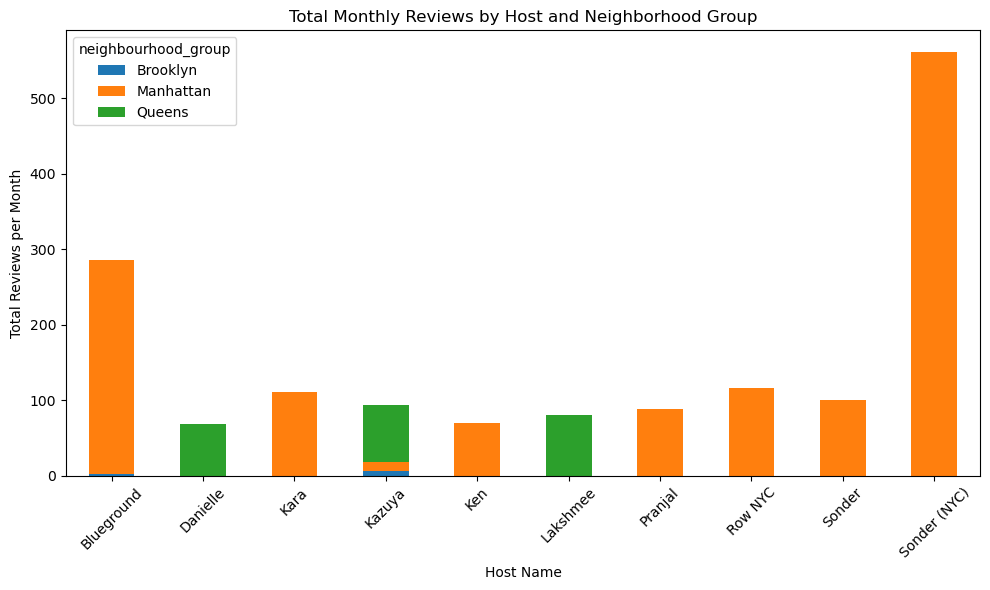

In [2088]:
total_reviews_per_host = df.groupby('host_id')['reviews_per_month'].sum().nlargest(10)
top_host_ids = total_reviews_per_host.index

top_hosts_df = df[df['host_id'].isin(top_host_ids)]

pivot = top_hosts_df.pivot_table(
    index='host_name', columns='neighbourhood_group', 
    values='reviews_per_month', aggfunc='sum'
).fillna(0)

pivot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Total Monthly Reviews by Host and Neighborhood Group')
plt.ylabel('Total Reviews per Month')
plt.xlabel('Host Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

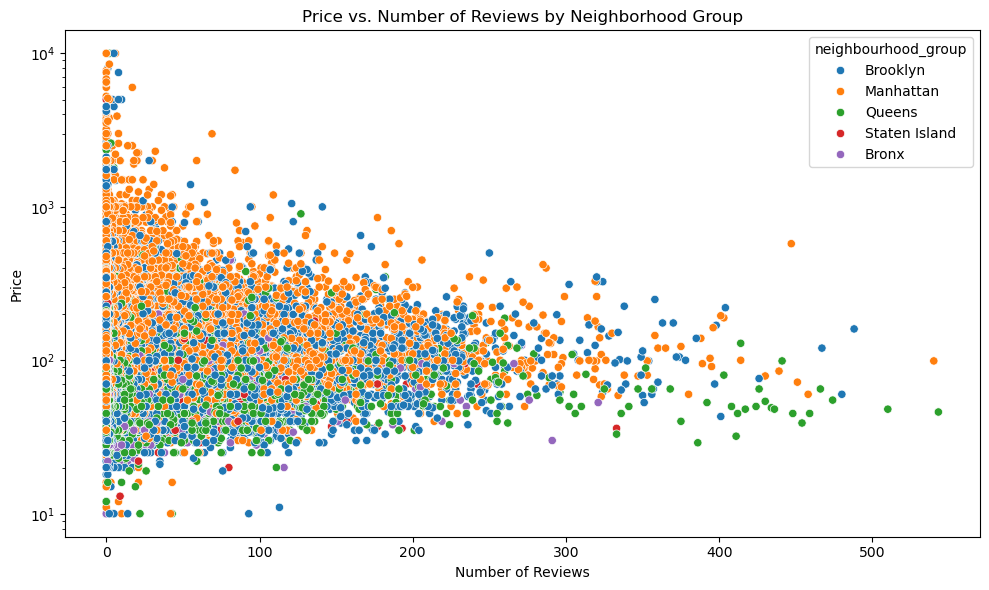

In [2089]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='number_of_reviews', y='price', hue='neighbourhood_group')
plt.title('Price vs. Number of Reviews by Neighborhood Group')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.yscale('log') 
plt.tight_layout()
plt.show()


In [2090]:
all_hosts = df.groupby(['host_id', 'host_name'])['reviews_per_month'].sum().reset_index()
busiest_hosts = all_hosts.sort_values(by='reviews_per_month', ascending=False)

listings_per_host = df['host_id'].value_counts().reset_index()
listings_per_host.columns = ['host_id', 'num_listings']

host_summary = busiest_hosts.merge(listings_per_host, on='host_id')
host_summary['reviews_per_listing'] = host_summary['reviews_per_month'] / host_summary['num_listings']

host_summary.head(10)

,host_id,host_name,reviews_per_month,num_listings,reviews_per_listing
0,219517861,Sonder (NYC),562.219954,327,1.719327
1,107434423,Blueground,285.961922,232,1.232594
2,244361589,Row NYC,115.836499,9,12.870722
3,30283594,Kara,110.968970,121,0.917099
4,12243051,Sonder,100.585141,96,1.047762
5,137358866,Kazuya,94.032647,103,0.912938
6,200380610,Pranjal,88.818642,65,1.366441
7,232251881,Lakshmee,80.630000,8,10.078750
8,22541573,Ken,70.113982,87,0.805908
9,26432133,Danielle,68.020000,5,13.604000


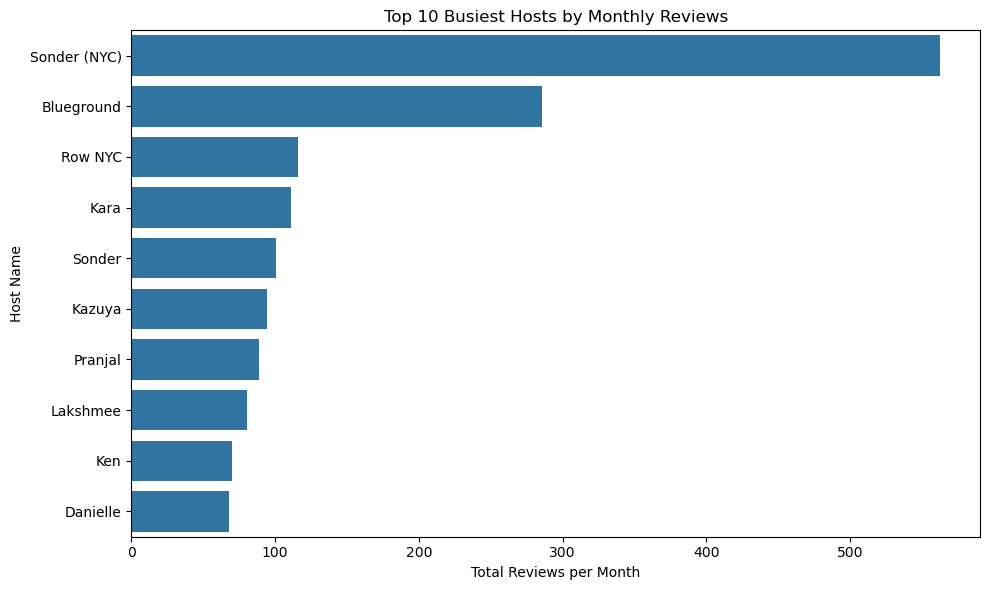

In [2091]:
top_hosts = host_summary.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_hosts, x='reviews_per_month', y='host_name')
plt.title('Top 10 Busiest Hosts by Monthly Reviews')
plt.xlabel('Total Reviews per Month')
plt.ylabel('Host Name')
plt.tight_layout()
plt.show()

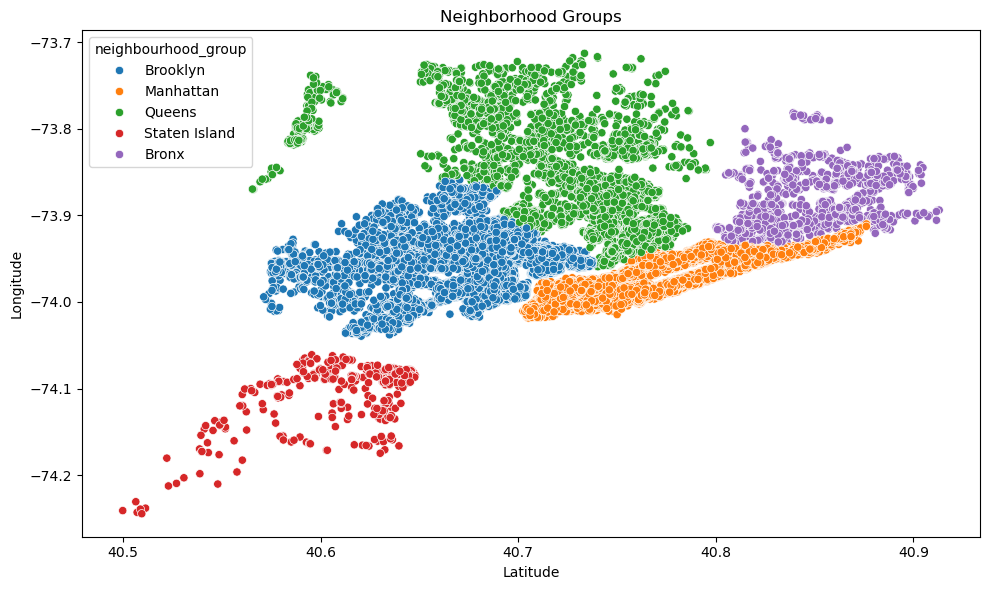

In [2092]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='latitude', y='longitude', hue='neighbourhood_group')
plt.title('Neighborhood Groups')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.tight_layout()
plt.show()


In [2093]:
df.head()

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365
1,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355
2,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1.372166,1,365
3,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194
4,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0


In [2094]:
df.isnull().sum()

host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10036
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [2095]:
df['norm_reviews'] = np.log1p(df['number_of_reviews']) / np.log1p(df['number_of_reviews']).max()
df['norm_price'] = np.log1p(df['price']) / np.log1p(df['price']).max()

df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['days_since_review'] = (pd.Timestamp.today() - df['last_review']).dt.days
df['days_since_review'] = df['days_since_review'].fillna(df['days_since_review'].max())
df['norm_recency'] = 1 - (df['days_since_review'] / df['days_since_review'].max())


df['host_num_listings'] = df.groupby('host_id')['host_id'].transform('count')
df['host_total_reviews'] = df.groupby('host_id')['number_of_reviews'].transform('sum')
df['host_avg_reviews_per_month'] = df.groupby('host_id')['reviews_per_month'].transform('mean')
df['popularity'] = (
    0.4 * df['norm_reviews'] +
    0.3 * df['norm_price'] +
    0.3 * df['norm_recency']
)

df.drop(['host_id','host_name', 'last_review', 'days_since_review','norm_reviews', 'norm_price', 'norm_recency'], axis=1, inplace=True)

In [2096]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
host_num_listings                 0
host_total_reviews                0
host_avg_reviews_per_month        0
popularity                        0
dtype: int64

In [2097]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_num_listings,host_total_reviews,host_avg_reviews_per_month,popularity
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365,6,105,0.480000,0.470007
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355,2,46,0.230000,0.592708
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.372166,1,365,1,0,1.372166,0.163421
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194,1,270,4.640000,0.677956
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0,1,9,0.100000,0.451739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,1.372166,2,9,2,16,1.011083,0.138843
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,1.372166,2,36,2,0,1.372166,0.120957
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,1.372166,1,27,1,0,1.372166,0.154833
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,1.372166,6,2,6,373,6.048694,0.131113


## DATASET PREPARATION

In [2098]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = df.drop(columns=['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object']).columns.tolist()

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[categorical_columns])

X_train_cat = ohe.transform(X_train[categorical_columns])
X_test_cat = ohe.transform(X_test[categorical_columns])

encoded_categorical_columns = ohe.get_feature_names_out(categorical_columns)

X_train_cat_df = pd.DataFrame(X_train_cat, columns=encoded_categorical_columns, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=encoded_categorical_columns, index=X_test.index)

X_train_num_df = X_train[numerical_columns].reset_index(drop=True)
X_test_num_df = X_test[numerical_columns].reset_index(drop=True)

X_train_final = pd.concat([X_train_num_df, X_train_cat_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_num_df, X_test_cat_df.reset_index(drop=True)], axis=1)

In [2099]:
list(X_train_final.columns)

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'host_num_listings',
 'host_total_reviews',
 'host_avg_reviews_per_month',
 'neighbourhood_group_Bronx',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_Staten Island',
 'neighbourhood_Allerton',
 'neighbourhood_Arden Heights',
 'neighbourhood_Arrochar',
 'neighbourhood_Arverne',
 'neighbourhood_Astoria',
 'neighbourhood_Bath Beach',
 'neighbourhood_Battery Park City',
 'neighbourhood_Bay Ridge',
 'neighbourhood_Bay Terrace',
 'neighbourhood_Bay Terrace, Staten Island',
 'neighbourhood_Baychester',
 'neighbourhood_Bayside',
 'neighbourhood_Bayswater',
 'neighbourhood_Bedford-Stuyvesant',
 'neighbourhood_Belle Harbor',
 'neighbourhood_Bellerose',
 'neighbourhood_Belmont',
 'neighbourhood_Bensonhurst',
 'neighbourhood_Bergen Beach',
 'neighbourhood_Boerum Hill',


## MODEL BUILDING AND TRAINING

In [2100]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

xgb_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
rf_model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
meta_model = Ridge()

stacked_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
    ],
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stacked_model.fit(X_train_final, np.log1p(y_train))

y_pred_log = stacked_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 0.005544658315983429
RMSE: 0.010090028362944304
R² Score: 0.995753521267042


## MODEL PERFORMANCE VISUALIZATION

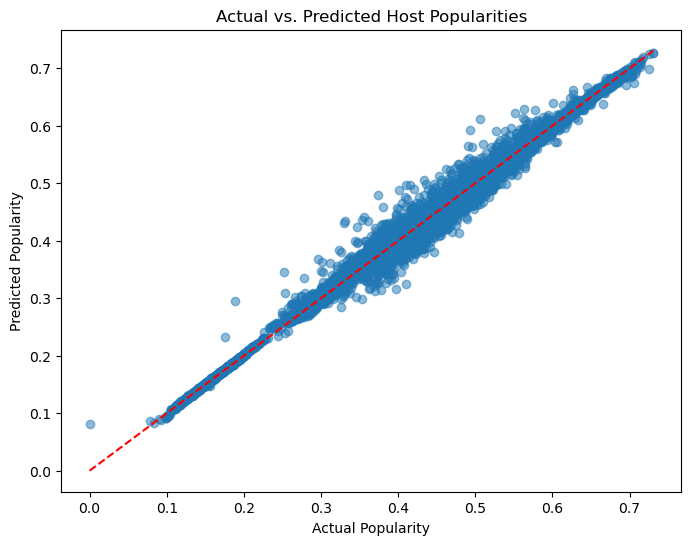

In [2101]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Host Popularities')
plt.show()

## FEATURES PERFORMANCE VISUALIZATION

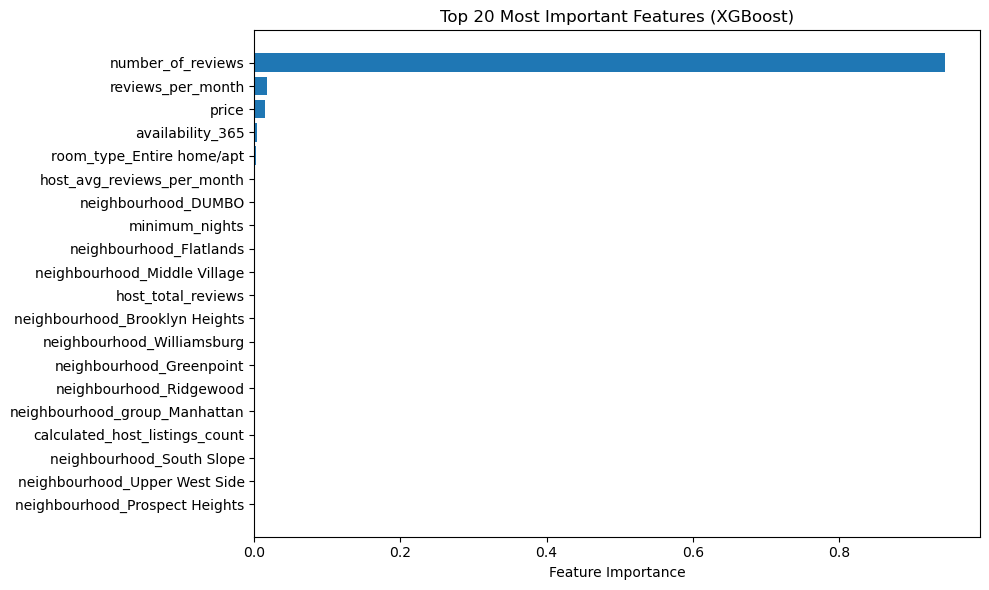

In [2102]:
import matplotlib.pyplot as plt

feat_importance = stacked_model.named_estimators_['xgb'].feature_importances_
sorted_idx = np.argsort(feat_importance)[::-1]
top_features = X_train_final.columns[sorted_idx[:20]]
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], feat_importance[sorted_idx[:20]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features (XGBoost)")
plt.tight_layout()
plt.show()

## MODEL AND TRAINED DATASET SAVING

In [2103]:
import joblib

joblib.dump(stacked_model, 'model.pkl')
joblib.dump(X_train_final, 'X_train_final.pkl')

['X_train_final.pkl']